In [1]:
%matplotlib inline

# this version use standard CEP to update U (explicit store and update msg_U) 
import sys
sys.path.append('./..')
import numpy as np
import torch 
import matplotlib.pyplot as plt
from model_LDS_tucker_full_efficient import LDS_CEP_tucker_full_efficient
import os
import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
JITTER = 1e-4
import utils
from sklearn.decomposition import PCA
from matplotlib.ticker import NullFormatter
torch.manual_seed(2)

In [2]:
# load data

data = np.load('../../data/dblp/dblp_year_1.npy', allow_pickle=True)

train_ind = data.item().get('train_ind')
train_y = data.item().get('train_y')
train_time = data.item().get('train_time_uni') # sorted & unique timestamps
train_time_disct = data.item().get('train_time_disct')
train_time_ind = data.item().get('train_time_ind')


test_ind = data.item().get('test_ind')
test_y = data.item().get('test_y')
test_time = data.item().get('test_time_uni')
test_time_ind = data.item().get('test_time_ind')
test_time_disct = data.item().get('test_time_disct')

ndims = data.item().get('ndims')

nmod = len(ndims)
N = train_y.size
N_time = train_time.size

R_U = 7
device = torch.device("cpu")

nepoch=40
gamma_size = np.prod([R_U for k in range(nmod)])

time_data_table = utils.build_time_data_table(train_time_ind)

U = [torch.rand(ndim,R_U).double() for ndim in ndims]


train_time = torch.tensor(train_time)
test_time = torch.tensor(test_time)

fix_int = None
time_int_list_follow = [train_time[i+1] - train_time[i] for i in range(N_time-1)]
time_int_list =torch.tensor([0.0] + time_int_list_follow)

train_y = torch.tensor(train_y).reshape(-1,1)
test_y = torch.tensor(test_y).reshape(-1,1)


# hyper-paras setting for LDS system
lengthscale = torch.tensor(0.1)
variance = torch.tensor(0.1)
noise = torch.tensor(0.1)

# matern 32 kernel
lamb = np.sqrt(3)/lengthscale
F_base = torch.tensor([[0,1.0],
                [-lamb*lamb,-2*lamb]])
P_inf_base = torch.tensor([[variance,0.0],
                    [0,lamb*lamb*variance]])
H_base = torch.tensor([[1.0,0]])

F_list =[F_base for i in range(gamma_size)]
P_inf_list =[P_inf_base for i in range(gamma_size)]
H_list = [H_base for i in range(gamma_size)]

F = torch.block_diag(*F_list)
P_inf = torch.block_diag(*P_inf_list)
H = torch.block_diag(*H_list)


m_0 = torch.zeros(2*gamma_size,1)
P_0 = P_inf

# package the hypyerparas

hyper_para_dict = {}
hyper_para_dict['N'] = N
hyper_para_dict['F'] = F
hyper_para_dict['H'] = H
hyper_para_dict['R'] = noise
hyper_para_dict['P_inf'] = P_inf
hyper_para_dict['fix_int'] = fix_int # set as None if it's not fix 
hyper_para_dict['m_0'] = m_0
hyper_para_dict['P_0'] = P_0

hyper_para_dict['U'] = U
hyper_para_dict['device'] = device
hyper_para_dict['ind_tr'] = train_ind
hyper_para_dict['y_tr'] = train_y

hyper_para_dict['test_ind'] = test_ind
hyper_para_dict['test_y'] = test_y

hyper_para_dict['epoch'] = nepoch
hyper_para_dict['R_U'] = R_U
hyper_para_dict['v'] = 1
hyper_para_dict['a0'] = 10.0
hyper_para_dict['b0'] = 1.0
hyper_para_dict['time_int_list'] = time_int_list
hyper_para_dict['ndims'] = ndims
hyper_para_dict['train_time'] = train_time
hyper_para_dict['test_time'] = test_time

hyper_para_dict['train_time_ind'] = train_time_ind
hyper_para_dict['test_time_ind'] = test_time_ind
hyper_para_dict['N_time'] = N_time
hyper_para_dict['time_data_table'] = time_data_table
hyper_para_dict['gamma_size'] = gamma_size

hyper_para_dict['DAMPPING_U'] = 0.6
hyper_para_dict['DAMPPING_gamma'] = 0.8

In [3]:
model_class = LDS_CEP_tucker_full_efficient
model = model_class(hyper_para_dict)

expand_odrer = 'two'
# expand_odrer = 'one'



for i in tqdm.tqdm(range(40)):
    # for i in range(args.epoch):
    
    # LDS
    model.reset_list()
            
    # for k in tqdm.tqdm(range(model.N_time)):
    for k in range(model.N_time):

        model.msg_update_tau(time_id=k)
        model.filter_predict(ind=k)

        if expand_odrer == 'two':
            # two-order expand of conditional moment
            msg_gamma_m,msg_gamma_v = model.msg_update_gamma(time_id=k)
            model.filter_update_general(y= msg_gamma_m,R = msg_gamma_v )

        else:
            # one-order expand of conditional moment
            data_id = model.time_data_table[k]
            if len(data_id)>1:
                # more that one data-llk 
                R = torch.diag((model.msg_b[data_id]/model.msg_a[data_id]).squeeze())
                z = model.E_z[data_id].squeeze(-1).T
            else:
                data_id = data_id[0]
                R = model.msg_b[data_id]/model.msg_a[data_id]
                z = model.E_z[data_id]
            # print(z.shape)
            model.filter_update_simple(y= model.y_tr[data_id], R= R,z = z)

    model.smooth()
    del model.P_pred_list
    del model.P_list
    model.post_update_gamma()

    # tau
    model.post_update_tau()
    model.expectation_update_tau()
    # CEP 
    # U
    model.msg_update_U()
    model.post_update_U() 
    # model.expectation_update_z()

    if i % 2 == 0:
        loss_test_rmse,loss_test_MAE = model.model_test(hyper_para_dict['test_ind'],hyper_para_dict['test_y'],hyper_para_dict['test_time'])
        print('loss_test_rmse: %.4f,loss_test_MAE: %.4f'%(loss_test_rmse,loss_test_MAE) )


  0%|          | 0/40 [00:00<?, ?it/s]/home/zenus/anaconda3/envs/pytorch_1.10.1/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,
/home/zenus/fang/SDE_GP_tensor/code_fang/notebook/./../model_LDS_tucker_full_efficient.py:198: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tid = self.train_time_ind[eid] # id time states of such entries
/home/zenus/fang/SDE_GP_tensor/code_fang/notebook/./../model_LDS_tucker_full_efficient.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing 

loss_test_rmse: 0.8674,loss_test_MAE: 0.8361


  8%|▊         | 3/40 [00:52<10:40, 17.31s/it]

loss_test_rmse: 0.3525,loss_test_MAE: 0.2370


 12%|█▎        | 5/40 [01:25<09:54, 16.99s/it]

loss_test_rmse: 0.2118,loss_test_MAE: 0.0958


 12%|█▎        | 5/40 [01:28<10:21, 17.76s/it]


KeyboardInterrupt: 

In [79]:
# gamma = model.post_gamma_m.squeeze().cpu().numpy()
# np.save('BCTT_dblp_post_W_r7', gamma)
gamma_raw = np.load('BCTT_dblp_post_W_r7.npy')

In [80]:
from sklearn.preprocessing import StandardScaler
import tensorly as tl
gamma = StandardScaler().fit_transform(gamma_raw)

t1=1
t2=6
t3=7

gamma1 = tl.tensor(gamma[t1,:].reshape(R_U,R_U,R_U))
gamma2 = tl.tensor(gamma[t2,:].reshape(R_U,R_U,R_U))
gamma3 = tl.tensor(gamma[t3,:].reshape(R_U,R_U,R_U))

# fold at dim1 
mode =2
gamma1_fold = tl.unfold(gamma1,mode).T.numpy()
gamma2_fold = tl.unfold(gamma2,mode).T.numpy()
gamma3_fold= tl.unfold(gamma3,mode).T.numpy()



pca = PCA(n_components=2)
X_1 = pca.fit(gamma1_fold).transform(gamma1_fold)
X_2 = pca.fit(gamma2_fold).transform(gamma2_fold)
X_3 = pca.fit(gamma3_fold).transform(gamma3_fold)

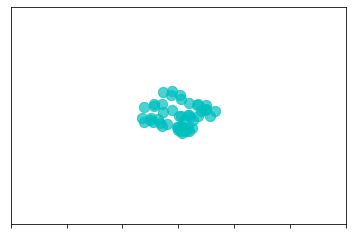

In [159]:
plt.scatter(X_1[:,0],X_1[:,1],c='c',s=105,alpha=0.7)
# plt.scatter(X_2[:,0],X_2[:,1],c='r')
# plt.scatter(X_3[:,0],X_3[:,1],c='b')
ax = plt.gca()
ax.set_xlim([-0.6, 0.6])
ax.set_ylim([-0.02, 0.02])
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig('core_pca_t1.pdf')


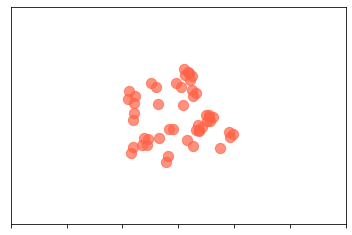

In [160]:
plt.scatter(X_2[:,0],X_2[:,1],c='tomato',s=105,alpha=0.7)
ax = plt.gca()
ax.set_xlim([-0.6, 0.6])
ax.set_ylim([-0.02, 0.02])
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig('core_pca_t2.pdf')

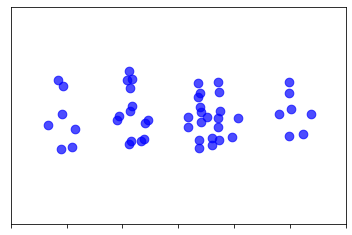

In [117]:
plt.scatter(X_3[:,0],X_3[:,1],c='b',s=75,alpha=0.7)
ax = plt.gca()
ax.set_xlim([-0.6, 0.6])
ax.set_ylim([-0.02, 0.02])
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig('core_pca_t3.pdf')

In [127]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(X_3.astype('double'))

x_min, x_max = -0.6, 0.6
y_min, y_max = -0.02, 0.02

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max,0.002))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

In [141]:
X_id = kmeans.predict(X_3.astype('double'))


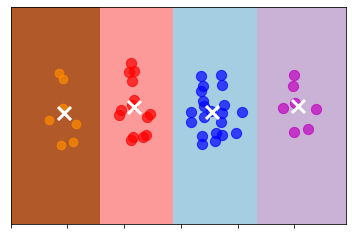

In [166]:
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt. imshow(
    Z,
    interpolation="antialiased",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

X_group1 = X_3[np.where(X_id==0)]
X_group2 = X_3[np.where(X_id==1)]
X_group3 = X_3[np.where(X_id==2)]
X_group4 = X_3[np.where(X_id==3)]

plt.scatter(X_group1[:,0],X_group1[:,1],c='b',s=105,alpha=0.7)
plt.scatter(X_group2[:,0],X_group2[:,1],c='r',s=105,alpha=0.7)
plt.scatter(X_group3[:,0],X_group3[:,1],c='m',s=105,alpha=0.7)
plt.scatter(X_group4[:,0],X_group4[:,1],c='darkorange',s=75,alpha=0.7)



centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=5,
)

ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.savefig('core_pca_t3.pdf')